# CNN
卷积神经网络可以以下图概括    

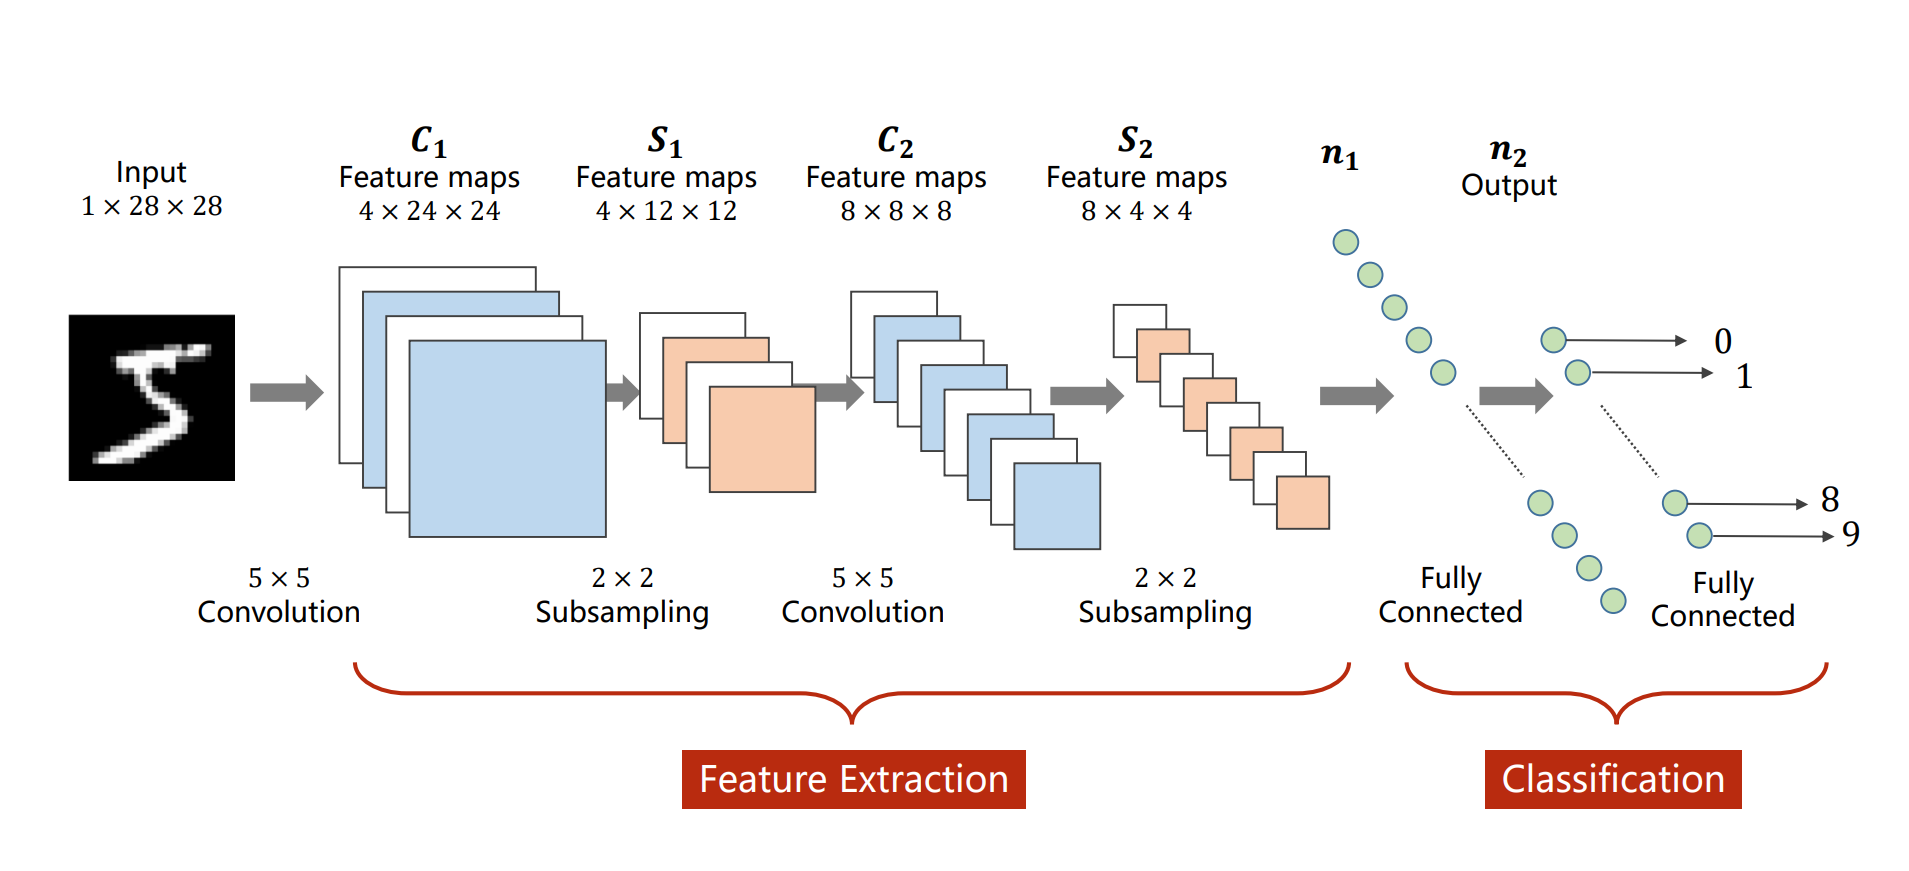

### 举例说明
假设有一张图片尺寸为25 * 25 * 3，其中25代表长和宽，3代表三个RGB通道，那么这个就是图像输入

##### 卷积核
卷积核则可以为5 * 5 * 3，期中5代表卷积核的长和宽，3代表卷积核的通道数，注意
- 一个卷积核是三维的，而不是单纯的二维5 * 5，通道数也要算在内
- 卷积核的第三个维度/第一个维度，一定要和图像的通道数一致
- 每个通道的卷积权重数值是不一样的
由此25 * 25的图像在5 * 5的卷积计算下得到的特征尺寸为21 * 21，算上通道数则为21 * 21 * 3
最后，在卷积计算完成后，每个通道数的结果需要拼在一起合并，即最后的输出是21 * 21 * 1

##### 步长
卷积核在计算的时候，一次可能移动不止1步，如果移动2步，上面的卷积结果就变为
(25 - 5)/ 2 + 1 = 11，即11 * 11

##### 填充
如果考虑到填充，比如在外部填充一层，那么卷积结果为
(25 - 5 + 1 * 2)/2 + 1 = 12，即12 * 12

综上，单纯考虑卷积运算，不考虑通道数，输入和输出的关系如下
$$
输出 = \frac{图像长/宽 - 卷积核长/宽 + 填充 * 2}{步长} + 1
$$

##### 池化
池化分为最大池化和平均池化，在一个n * n的尺寸下计算即可，注意这里不是一步步平移的，池化的尺寸计算如下
$$
输出 = \frac{输入长/宽 - 池化核长/宽}{步长} + 1
$$

##### 整体维度
如下图所示，之所以CNN总是让人感觉越来越粗是因为其粗细取决于卷积核的个数，有m个卷积和那么一层卷积计算后的长度即为m
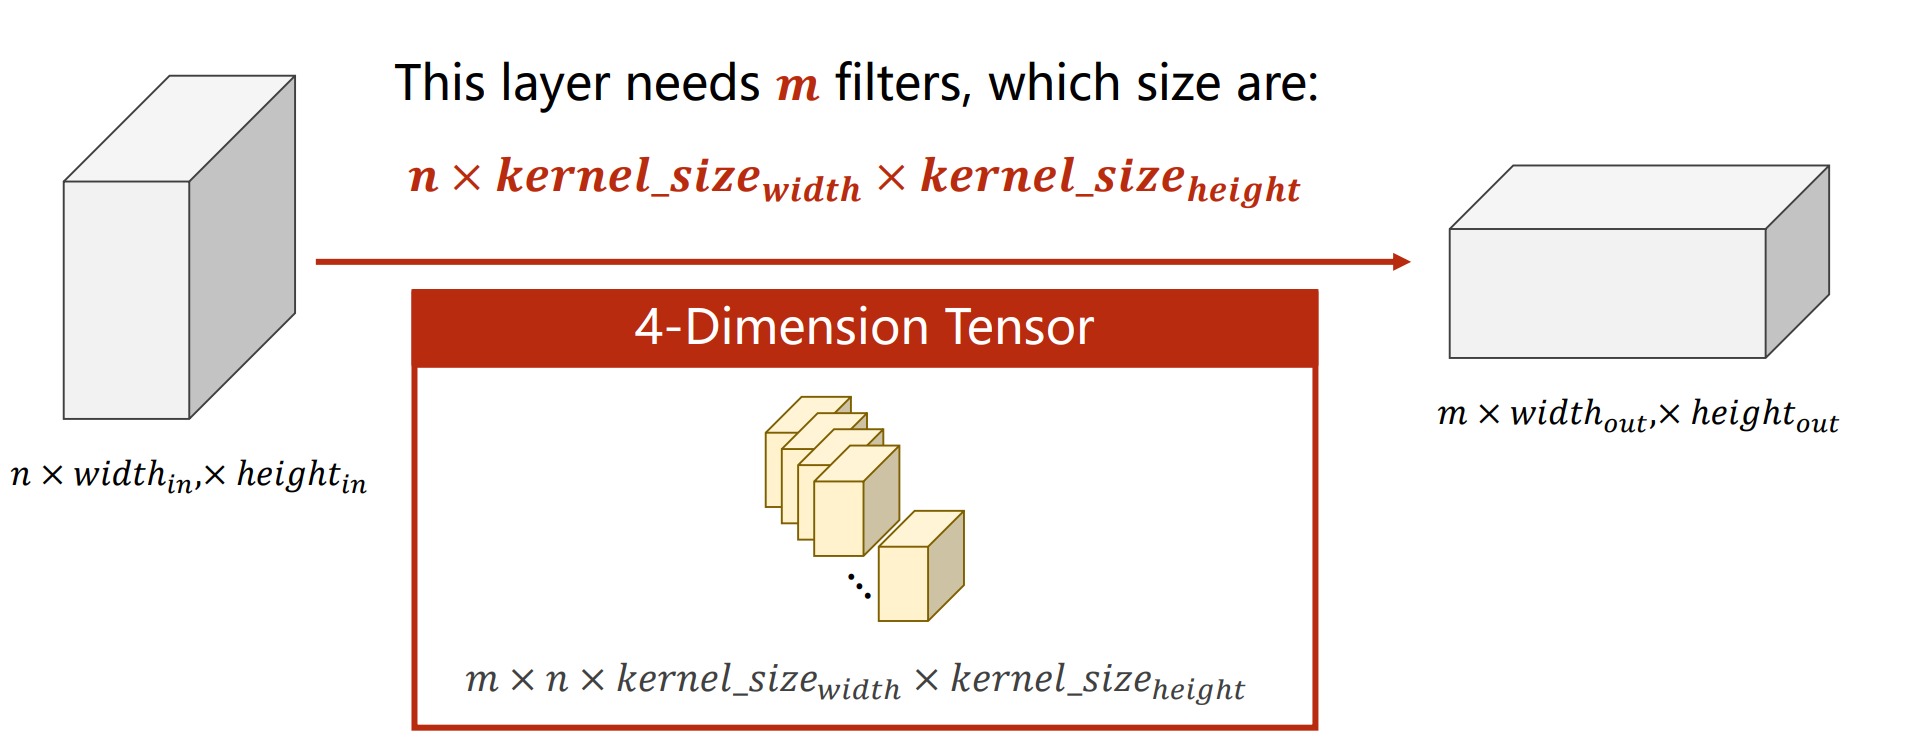

### 经典CNN之LeNet实现

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        # 卷积层：输入通道 1，输出通道 6，卷积核 5×5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # 池化层：2×2 平均池化
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # 卷积层：输入通道 6，输出通道 16，卷积核 5×5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 池化层：2×2 平均池化
        self.pool2 = nn.AvgPool2d(2, 2)
        # 全连接层：16×5×5 → 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 全连接层：120 → 84
        self.fc2 = nn.Linear(120, 84)
        # 全连接层：84 → num_classes
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # x: [batch, 1, 32, 32]
        x = F.relu(self.conv1(x))   # → [batch, 6, 28, 28]
        x = self.pool1(x)           # → [batch, 6, 14, 14]
        x = F.relu(self.conv2(x))   # → [batch, 16, 10, 10]
        x = self.pool2(x)           # → [batch, 16, 5, 5]
        x = x.view(x.size(0), -1)   # 拉平 → [batch, 16*5*5]
        x = F.relu(self.fc1(x))     # → [batch, 120]
        x = F.relu(self.fc2(x))     # → [batch, 84]
        x = self.fc3(x)             # → [batch, num_classes]
        return x

if __name__ == "__main__":
    # 实例化模型
    model = LeNet5(num_classes=10)
    # 生成随机输入：batch_size=4，单通道，32×32 图像
    inputs = torch.randn(4, 1, 32, 32)
    # 前向传播
    outputs = model(inputs)
    print("输入形状:", inputs.shape)
    print("输出形状:", outputs.shape)  # 应该是 [4, 10]


### 经典CNN之AlexNet实现

AlexNet 相比 LeNet 的主要改进
1. 更深、更宽的网络结构
- LeNet 只有 2 个卷积层，AlexNet 扩展到 5 层卷积，通道数也大幅增加（从最多 16→256），大大增强了表达能力。

2. 大感受野的首层设计
- AlexNet 第一层使用了 11×11、stride=4 的大卷积核，能够迅速增大感受野，捕捉输入的全局信息；LeNet 则用的是 5×5。

3. ReLU 激活
-首次在大规模网络中采用了 ReLU 替代 sigmoid/tanh，加速了收敛并缓解了梯度消失。

4. 最大池化 (MaxPool) 替代平均池化
- AlexNet 中多处使用 MaxPool2d，能够更强地保留显著特征；LeNet 最初使用的是 AvgPool（子采样）。

5. Dropout
- 在全连接层中引入 Dropout（丢弃率默认 0.5），有效抑制过拟合；LeNet 并无此机制。

6. 局部响应归一化 (LRN)
- 原始论文里还使用了 LRN 来增强“亮点”响应，不过在很多现代实现中可用 BatchNorm 代替或省略。

7. 更大的输入尺寸
- AlexNet 处理 224×224 的彩色图像，而 LeNet 通常只针对 32×32 的灰度小图。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        # 特征提取部分：5 层卷积 + 3 次最大池化
        self.features = nn.Sequential(
            # C1: 3→64, 11×11 卷积, 步幅4, pad2
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # C2: 64→192, 5×5 卷积, pad2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # C3: 192→384, 3×3 卷积, pad1
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # C4: 384→256, 3×3 卷积, pad1
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # C5: 256→256, 3×3 卷积, pad1
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 分类部分：3 层全连接 + Dropout
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # 拉平
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

if __name__ == "__main__":
    # 实例化并测试前向传播
    model = AlexNet(num_classes=1000)
    # 随机输入：batch=4, 通道=3, 尺寸=224×224
    inputs = torch.randn(4, 3, 224, 224)
    outputs = model(inputs)
    print("输入形状:", inputs.shape)    # torch.Size([4, 3, 224, 224])
    print("输出形状:", outputs.shape)  # torch.Size([4, 1000])


### 经典CNN之VGG

VGG 相比 LeNet/AlexNet 的主要改进
1. 更深的网络结构

VGG-16 在卷积部分堆叠了 13 个卷积层（+ 5 个池化），总层数超过 16 层，而 AlexNet 只有 5 层卷积，LeNet 仅 2 层。更深的网络能够抽取更高层次、更抽象的特征。

统一的小卷积核设计

全部使用 $3\times3$ 卷积核（padding=1 保持尺寸），多个 $3\times3$ 卷积叠加的感受野等价于一个大卷积核（例如两个 $3\times3$ 等同于一个 $5\times5$），但参数更少、非线性更多。

更多的非线性激活

每个卷积层后都紧跟 ReLU，相比 AlexNet 在每对大卷积后才有一次 ReLU，VGG 在更细粒度上增加了非线性，提升了表达能力和网络深度的有效利用。

更严格的架构规范

VGG 提出了“层叠 $3\times3$ + ReLU + 池化”的固定模块化设计，易于重复使用和扩展；AlexNet 则在不同层使用了不同大小卷积核，架构相对杂糅。

大量的参数与更强的拟合能力

VGG-16 全连接层就包含上亿级参数，总参数量达到 $\sim$138M，相比 AlexNet 的 $\sim$60M 更大，能够拟合更复杂的模式（代价是更多的计算和存储）。

更深通道宽度

随着网络加深，通道数从 64、128→256、512 逐步增长，能层次化地提取从低级边缘纹理到高级语义区域的特征。

In [ ]:
import torch
import torch.nn as nn

# VGG-16 的配置表
cfgs = {
    'VGG16': [64, 64, 'M',
              128, 128, 'M',
              256, 256, 256, 'M',
              512, 512, 512, 'M',
              512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, arch='VGG16', num_classes=1000):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfgs[arch])
        # 最后 feature map 大小为 512×7×7 → 展平 → FC
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        # 最后再加一个全局平均（可选），原版用的是直接输出 feature map
        return nn.Sequential(*layers)


if __name__ == "__main__":
    model = VGG('VGG16', num_classes=1000)
    # 随机输入：batch=4, 通道=3, 尺寸=224×224
    inputs = torch.randn(4, 3, 224, 224)
    outputs = model(inputs)
    print("输入形状:", inputs.shape)    # torch.Size([4, 3, 224, 224])
    print("输出形状:", outputs.shape)  # torch.Size([4, 1000])


### 经典CNN之NiN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NiN(nn.Module):
    def __init__(self, num_classes=1000):
        super(NiN, self).__init__()
        self.features = nn.Sequential(
            # Block1
            nn.Conv2d(3, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 160, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(160, 96, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.5),
            # Block2
            nn.Conv2d(96, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.5),
            # Block3
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            # 全局平均池化，输出 num_classes 个通道
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.features(x)            # [batch, num_classes, 1, 1]
        x = x.view(x.size(0), -1)       # 拉平成 [batch, num_classes]
        return x

if __name__ == "__main__":
    model = NiN(num_classes=1000)
    # 随机输入：batch=4, 通道=3, 尺寸=224×224
    inputs = torch.randn(4, 3, 224, 224)
    outputs = model(inputs)
    print("输入形状:", inputs.shape)    # torch.Size([4, 3, 224, 224])
    print("输出形状:", outputs.shape)  # torch.Size([4, 1000])


### 经典CNN之GoogleNet

### 经典CNN之ResNet